In [23]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import xgboost as xgb
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

In [3]:
sig_files = [f for f in os.listdir('.') if '.h5' in f and 'signal' in f]
bkg_files = [f for f in os.listdir('.') if '.h5' in f and 'bkg' in f]

variables = ['lead_jet_eta','lead_jet_pt','jetMETdPhi','minJetMETdPhi','sel_vtx_sign',
             'sel_vtx_chi2','sel_vtx_METdPhi','sel_vtx_m','sel_vtx_dR','sel_vtx_minDxy',
             'met_leadPt_ratio','vxy_signif']
sig_data = []
for sf in sig_files:
    with h5py.File(sf,"r") as fin:
        match = fin["sel_vtx_match"][()]
        mask = match==2
        sig_data.append(np.concatenate([fin[v][()][mask].reshape(-1,1) for v in variables],axis=1))
sig_data = np.concatenate(sig_data,axis=0)

bkg_data = []
for bf in bkg_files:
    with h5py.File(bf,"r") as fin:
        bkg_data.append(np.concatenate([fin[v][()].reshape(-1,1) for v in variables],axis=1))
bkg_data = np.concatenate(bkg_data,axis=0)

In [28]:
rng = np.random.default_rng(seed=438290)
sig_train,sig_test = train_test_split(sig_data,train_size=0.8,random_state=rng.integers(0,100000,1)[0])
bkg_train,bkg_test = train_test_split(bkg_data,train_size=0.8,random_state=rng.integers(0,100000,1)[0])

train = np.concatenate((sig_train,bkg_train),axis=0)
y_train = np.concatenate((np.ones(len(sig_train)),np.zeros(len(bkg_train))),axis=0)
perm = rng.permutation(len(train))
train = train[perm]
y_train = y_train[perm]
dtrain = xgb.DMatrix(train,label=y_train,feature_names=variables)

test = np.concatenate((sig_test,bkg_test),axis=0)
y_test = np.concatenate((np.ones(len(sig_test)),np.zeros(len(bkg_test))),axis=0)
perm = rng.permutation(len(test))
test = test[perm]
y_test = y_test[perm]
dtest = xgb.DMatrix(test,label=y_test,feature_names=variables)

In [29]:
bst = xgb.XGBRegressor(n_estimators=5, max_depth=10, learning_rate=1, objective='binary:logistic')
# fit model
bst.fit(dtrain)
# make predictions
preds = bst.predict(dtest)

TypeError: fit() missing 1 required positional argument: 'y'

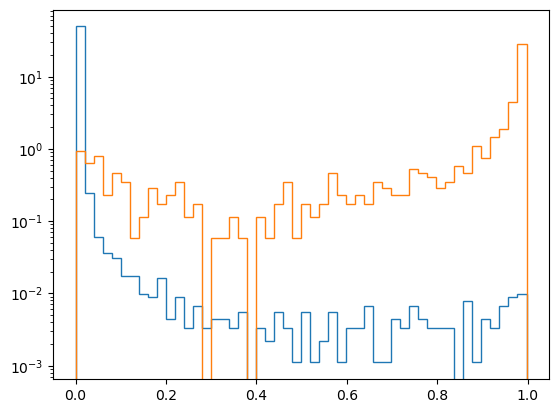

In [22]:
h,bins,_ = plt.hist(preds[y_test==0],bins=50,density=True,histtype='step')
h,bins,_ = plt.hist(preds[y_test==1],bins=bins,density=True,histtype='step')
plt.yscale('log')

In [30]:
dir(dtrain)

['__class__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_init_from_iter',
 'feature_names',
 'feature_types',
 'get_base_margin',
 'get_data',
 'get_float_info',
 'get_group',
 'get_label',
 'get_uint_info',
 'get_weight',
 'handle',
 'missing',
 'nthread',
 'num_col',
 'num_nonmissing',
 'num_row',
 'save_binary',
 'set_base_margin',
 'set_float_info',
 'set_float_info_npy2d',
 'set_group',
 'set_info',
 'set_label',
 'set_uint_info',
 'set_weight',
 'silent',
 'slice']

In [25]:
auc = roc_auc_score(y_test,preds)
print(auc)

0.9950296528112235


In [33]:
xgb.plot_importance(bst)
plt.gca().get_yticklabels()

NotFittedError: need to call fit or load_model beforehand

In [34]:
bst

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5, n_jobs=None, num_parallel_tree=None,
             objective='binary:logistic', predictor=None, ...)